### https://hwiyong.tistory.com/386?category=858475
### 원래 코드  Cosine annealing restart

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as backend
import math

class CosineAnnealingLearningRateSchedule(tf.keras.callbacks.Callback):
    def __init__(self, n_epochs, n_cycles, lrate_max, min_lr, verbose = 0):
        self.epochs = n_epochs
        self.cycles=  n_cycles
        self.lr_max = lrate_max
        self.min_lr = min_lr
        self.lrates = list()
    
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = math.floor(n_epochs/n_cycles)
        cos_inner = (math.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        
        return lrate_max/2 * (math.cos(cos_inner) + 1)
  
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs = None):
        if(epoch < 101):
            # calculate learning rate
            lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
#             print('\nEpoch %05d: CosineAnnealingScheduler setting learng rate to %s.' % (epoch + 1, lr))

        else:
            lr = self.min_lr

#         backend.set_value(self.model.optimizer.lr, lr)

        self.lrates.append(lr)

### Learning_rate 그래프 확인

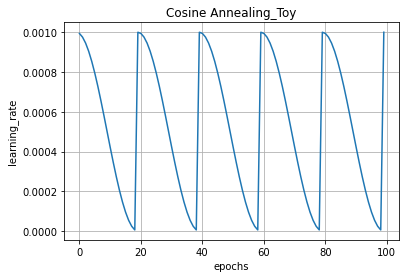

In [2]:
cosine_schedule = CosineAnnealingLearningRateSchedule(n_epochs = 100, n_cycles = 5, lrate_max = 1e-3, min_lr = 1e-6)

for i in range(1, 100 + 1):
    cosine_schedule.on_epoch_begin(i)
    
import matplotlib.pyplot as plt

plt.plot(cosine_schedule.lrates)
plt.title('Cosine Annealing_Toy')
plt.xlabel('epochs'); plt.ylabel('learning_rate')
plt.grid()
plt.show()

### tf.keras.optimizers.schedules.CosineDecayRestarts 에 
### warm up 추가해서 callback 함수로 구현

In [23]:
import tensorflow as tf
import tensorflow.keras.backend as K
import math

class CosineAnnealingWarmup(tf.keras.callbacks.Callback):
    def __init__(self, epochs_per_cycle,iteration, max_lr, min_lr, verbose = 1):
        self.epochs_per_cycle = epochs_per_cycle
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.iteration = iteration;
        self.steps = 0;
        self.learning_rate = max_lr;
        self.epochs = 0; # epoch to search min_lr for each iteration 
        self.warmup_epoch = 10  # warmup epcch
        self.verbose = verbose # log
        self.lrates = list() # for graph
        
        
    def cosine_annealing(self, epoch, epochs_per_cycle, max_lr):
        self.epochs += 1; 
        cos_inner = (math.pi * (self.epochs % epochs_per_cycle)) / (epochs_per_cycle)
        self.learning_rate = max_lr/2 * (math.cos(cos_inner) + 1)
        
        if ((self.epochs % epochs_per_cycle) == (epochs_per_cycle-1)):
            self.steps += 1
            self.max_lr *= 0.8
            self.epochs = 0;
            self.epochs_per_cycle = math.floor(self.epochs_per_cycle*1.2)
            
        return max_lr/2 * (math.cos(cos_inner) + 1)
  
    def warm_up(self, epoch):
        
        self.learning_rate = self.max_lr * epoch / self.warmup_epoch
        
        return self.learning_rate

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs = None):
        if (epoch < self.warmup_epoch):
            # warm up learning rate
            lr = self.warm_up(epoch)
       
        elif(self.steps < self.iteration):
            # calculate learning rate
            lr = self.cosine_annealing(epoch, self.epochs_per_cycle, self.max_lr)
            
        else:
            lr = self.min_lr
        
#         if (self.verbose == 1):
#             print('\nEpoch %05d: CosineAnnealingScheduler setting learng rate to %s.' % (epoch + 1, lr))  

        
#         K.set_value(self.model.optimizer.lr, lr)

        self.lrates.append(lr)

### Learning_rate 그래프 확인

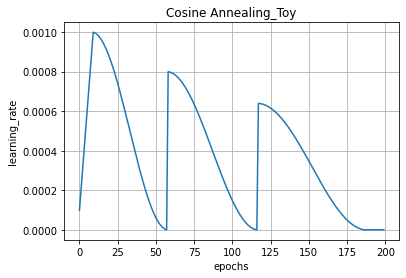

In [24]:
cosine_schedule = CosineAnnealingWarmup(epochs_per_cycle=50, iteration=3,max_lr = 1e-3, min_lr = 1e-6)

for i in range(1, 200 + 1):
    cosine_schedule.on_epoch_begin(i)
    
import matplotlib.pyplot as plt

plt.plot(cosine_schedule.lrates)
plt.title('Cosine Annealing_Toy')
plt.xlabel('epochs'); plt.ylabel('learning_rate')
plt.grid()
plt.show()

### Label Smoothing
#### 손실함수에 인자추가

In [1]:
from tensorflow.keras.losses import CategoricalCrossentropy
losses = CategoricalCrossentropy(label_smoothing=0.1)

### 데이터 불균형 처리를 위한 class_weight 가중치 

In [ ]:
weight_for_0 = (1 / count_class0)*(count_total)/count_class
weight_for_1 = (1 / count_class1)*(count_total)/count_class
weight_for_2 = (1 / count_class2)*(count_total)/count_class

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

### AdamW Optimizer 확실x
### https://github.com/shaoanlu/AdamW-and-SGDW/blob/master/AdamW.py

In [ ]:
from tensorflow.keras.optimizers import Adam
import six
import copy
from six.moves import zip
from tensorflow.keras import backend as K

class AdamW(Adam):
    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4,  # decoupled weight decay (1/6)
                 epsilon=1e-8, decay=0., **kwargs):
        super(AdamW, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.init_lr = lr # decoupled weight decay (2/6)
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.wd = K.variable(weight_decay, name='weight_decay') # decoupled weight decay (3/6)
        self.epsilon = epsilon
        self.initial_decay = decay

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]
        wd = self.wd # decoupled weight decay (4/6)

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        eta_t = lr / self.init_lr # decoupled weight decay (5/6)

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        self.weights = [self.iterations] + ms + vs

        for p, g, m, v in zip(params, grads, ms, vs):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            p_t = p - lr_t * m_t / (K.sqrt(v_t) + self.epsilon) - eta_t * wd * p # decoupled weight decay (6/6)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'weight_decay': float(K.get_value(self.wd)),
                  'epsilon': self.epsilon}
        base_config = super(AdamW, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

adamw= AdamW(lr=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-4, epsilon=1e-8, decay=0.)

### AdamW API
### TensorFlow Addons 이용해서 쓸 수 있음. 이게 베스트 노트북에서 확인함.
### https://www.tensorflow.org/addons/overview?hl=ko

In [ ]:
import tensorflow_addons as tfa
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.05)

### 각종 Callback

In [ ]:
model_folder = '.1/cal/2-2_inceptionV3/'
model_path = model_folder + '{epoch:02d}-{val_loss:.4f}.hdf5'


check_point = ModelCheckpoint(model_path, monitor = 'val_accuracy', save_best_only=False)
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=60, restore_best_weights=True)